# Modeling Climate and Housing Data
## Question 1: Can we predict real estate purchase price based on climate indicators?
## 90-803 Machine Learning Foundations with Python (Spring 2024)
### Team 17: Yoko, Tessa, Hannah

We are attempting to predict home values (or purchase prices) based on climate indicators, so in this file we are exploring the following:
* Linear Regression
* Polynomial Regressions
* Feature selection
* Ridge regression
* Lasso regression
* RANSAC Linear regression for exclusing outliers

At the bottom of the file in the Appendix, please find these methods that were attempted but failed to make the model better:
* Encoding the Year and Month columns and scaling them

### Load Libraries

In [58]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### Read and Explore the Data

This file was previously cleaned, merged, and exported to a CSV in the Merging_Data.ipynb notebook. Below, the file is read and double checked.

In [59]:
# Read and look at data.
data = pd.read_csv("all_data.csv", index_col=0)
data.head()

,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.93,8.01,15,103.0,173.6,64.7,7.0
1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,47.8,CA,0.81,8.20,30,129.9,166.8,81.1,61.1
2,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.93,8.01,15,103.0,173.6,64.7,7.0
3,2000-01-31,2000,1,Cook County,IL,71689.188026,302264.545103,24.9,2.4,22.5,IL,0.81,8.20,30,129.9,166.8,81.1,61.1
4,2000-01-31,2000,1,Harris County,TX,61195.175569,217850.462915,57.4,5.6,51.8,TX,0.93,8.01,15,103.0,173.6,64.7,7.0


We already have a 'Year' and 'Month' column. Since we don't want timeseries data, I am going to drop the 'Date' column. Furthermore, I am going to rename the 'Value' column to the more apt 'Average Temperature Value'. Finally, I am mapping the StateFPS code to the state name abbreviation so that we can merge with geospatial data.

In [60]:
# Drop date column
data.drop(columns=['Date'], inplace=True)

# Rename Value column
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)

# Map the state abbreviation tothe stateFPS in a new column
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)

### Read in Geo-data
We want to relate this data to where the counties exist in geospatial relation to one another, especially because Latitude and Longitude may be important features. So we are going to read the county shapefiles for the contiguous United States, and merge it into our dataset.

In [61]:
# Loading the shapefile in order to visualize clean data on the US map
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')
print(us_counties.columns)
us_counties.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477644346,10691216,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980770,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,None,None,A,2169272978,22847034,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645185,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [62]:
# Merge the geospatial United States map with the data
data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
print(data.columns)
data.head()

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Year', 'Month',
       'RegionName', 'State', 'Bottom-Tier Average Home Value Estimate',
       'Top-Tier Average Home Value Estimate', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'StateAbbrv',
       'Initial Fees and Charges (%)', 'Effective Rate (%)',
       'Term to Maturity', 'Loan Amount ($thou)', 'Purchase Price ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'StateFPS'],
      dtype='object')


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.93,8.01,15,103.0,173.6,64.7,7.0,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,22.2,NE,0.81,8.20,30,129.9,166.8,81.1,61.1,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.91,8.18,15,100.5,172.8,63.1,7.2,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,27.3,NE,0.78,8.39,30,127.8,163.7,81.2,58.6,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,38.0,NE,0.87,8.24,15,101.2,176.9,62.7,7.2,31


After merging, let's double check that we do not have null values that we do not expect. Note: I do expect some _irrelevant_ columns to contain Nulls because they are null in the shapefiles; but we are going to drop those columns.

In [63]:
# What does our dataframe look like right now?
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 579894 entries, 0 to 579893
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   STATEFP                                  579894 non-null  object  
 1   COUNTYFP                                 579894 non-null  object  
 2   COUNTYNS                                 579894 non-null  object  
 3   GEOID                                    579894 non-null  object  
 4   NAME                                     579894 non-null  object  
 5   NAMELSAD                                 579894 non-null  object  
 6   LSAD                                     579894 non-null  object  
 7   CLASSFP                                  579894 non-null  object  
 8   MTFCC                                    579894 non-null  object  
 9   CSAFP                                    0 non-null       object  
 10  CBSAFP      

**Note:** In the appendix, we explore encoding and scaling the Year and Month columns. This renders R2 values that are really bad (on the order of E+20 and higher). So, we are not including them to be scaled here, nor did we previously encode them.

In [64]:
# Extract the columns that we want to scale
columns_to_scale = data.drop(columns=['Year', 'Month', 'RegionName', 'State', 'StateFPS', 'StateAbbrv', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the specified columns
scaler.fit(data[columns_to_scale])

# Transform the data using the fitted scaler and convert it back to a DataFrame
scaled_data = scaler.transform(data[columns_to_scale])
data[columns_to_scale] = pd.DataFrame(scaled_data, columns=columns_to_scale, index=data.index)

# Display the first few rows of the scaled columns to verify the values look scaled at first glance
data[columns_to_scale].head()

,ALAND,AWATER,INTPTLAT,INTPTLON,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
0,-0.04576,-0.288067,0.605918,-0.559929,-0.256856,-0.391808,-1.569987,1.539034,-1.878226,0.105420,2.478430,-1.0,-2.007124,-2.350378,-0.913730,-1.040546
1,-0.04576,-0.288067,0.605918,-0.559929,-0.256856,-0.391808,-1.569987,1.539034,-1.878226,-0.223290,2.632607,1.0,-1.279980,-2.535091,1.004406,0.813359
2,-0.04576,-0.288067,0.605918,-0.559929,-0.254749,-0.390204,-1.108955,2.365461,-1.579980,0.050635,2.616377,-1.0,-2.074703,-2.372109,-1.100866,-1.033692
3,-0.04576,-0.288067,0.605918,-0.559929,-0.254749,-0.390204,-1.108955,2.365461,-1.579980,-0.305468,2.786784,1.0,-1.336746,-2.619298,1.016102,0.727689
4,-0.04576,-0.288067,0.605918,-0.559929,-0.252694,-0.388732,-0.653759,1.509519,-0.954246,-0.058935,2.665065,-1.0,-2.055781,-2.260738,-1.147649,-1.033692


In [65]:
# Let's also look at the dataframe as a whole to check that the rest of the data still looks kosher
data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.878226,NE,0.105420,2.478430,-1.0,-2.007124,-2.350378,-0.913730,-1.040546,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.878226,NE,-0.223290,2.632607,1.0,-1.279980,-2.535091,1.004406,0.813359,31
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.579980,NE,0.050635,2.616377,-1.0,-2.074703,-2.372109,-1.100866,-1.033692,31
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.579980,NE,-0.305468,2.786784,1.0,-1.336746,-2.619298,1.016102,0.727689,31
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-0.954246,NE,-0.058935,2.665065,-1.0,-2.055781,-2.260738,-1.147649,-1.033692,31


### Split the data
Because this data is origianlly time series, we have broken the year and month into their own columns and dropped the date. Next, we are going to use the latest year as the "test" dataset and all previous years as training.

In [66]:
# Test set is all of the last year of the dataset
test = data[data['Year'] == 2019].copy()

# Train set is all of the other years
train = data[data['Year'] != 2019].copy()

# Target is purchase price, training is done on all over columns EXCEPT irrelevant geospatial columns (which are still needed for plotting maps)
y_test = test['Purchase Price ($thou)'].copy()
y_train = train['Purchase Price ($thou)'].copy()
X_train = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
X_test = test.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()

# Look at the data for one of these -- looks OK
X_test.head()

,ALAND,AWATER,INTPTLAT,INTPTLON,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Loan-to-Price Ratio (%),Share of Total Market (%)
456,-0.04576,-0.288067,0.605918,-0.559929,2019,1,0.625861,0.142892,-1.791749,0.417454,-1.878226,1.475045,-0.426591,-1.0,0.579781,-0.609636,-1.074814
457,-0.04576,-0.288067,0.605918,-0.559929,2019,1,0.625861,0.142892,-1.791749,0.417454,-1.878226,0.790232,-0.045205,1.0,1.985413,1.016102,1.293113
458,-0.04576,-0.288067,0.605918,-0.559929,2019,2,0.634614,0.147498,-2.211930,-3.212921,-1.579980,1.036765,-0.613226,-1.0,0.663578,-0.551156,-1.050826
459,-0.04576,-0.288067,0.605918,-0.559929,2019,2,0.634614,0.147498,-2.211930,-3.212921,-1.579980,0.653270,-0.150695,1.0,1.725912,0.957622,1.159467
460,-0.04576,-0.288067,0.605918,-0.559929,2019,3,0.647434,0.153817,-1.272359,-1.619098,-0.954246,0.516307,-0.783632,-1.0,0.925783,-0.878642,-1.043973


### Model 1: Linear Regression
The first no-brainer model to try is a first-order linear regression with all features included. Below are some functions to facilitate running this model with different features selected.

In [74]:
def run_linear_model(X_train, y_train, X_test, y_test):
    """
    Constructs a LinearRegression object, fits the train data, and predicts the y_train and y_test data
    and prints the MSE and R2 values.
    X_train, y_train, X_test, y_test: training and testing data
    returns: r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model
    """
    # Construct the model, fit the data, and predict
    l_model = LinearRegression()
    l_model.fit(X_train, y_train)
    y_pred_train = l_model.predict(X_train)
    y_pred_test = l_model.predict(X_test)

    # Get R2 values
    r_squared_train_linear = r2_score(y_train, y_pred_train)
    r_squared_test_linear = r2_score(y_test, y_pred_test)

    # Get MSE values
    mean_squared_error_train_linear = mean_squared_error(y_train, y_pred_train)
    mean_squared_error_test_linear = mean_squared_error(y_test, y_pred_test)

    # Printing results for training
    print('r_squared_train:', round(r_squared_train_linear, 5))
    print('mean_squared_error_train:', round(mean_squared_error_train_linear, 5))

    # Printing results for testing
    print('r_squared_test:',round(r_squared_test_linear, 5))
    print('mean_squared_error_test:',round(mean_squared_error_test_linear, 5))
    return r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model

# Run the model with all of the features. Saving results to an object so that they don't needlessly print.
results = run_linear_model(X_train, y_train, X_test, y_test)

r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033


The training data did incredibly well where the test data did just OK. The MSE values for both are decently low but there is a mismatch with R2 values. This seems suspicious.

I am going to check which features are most important below.

## Feature Selection

In [68]:
# Run SequentialFeatureSelector using up to 12 features. (That number is arbitrarily slightly less than the number of features I have,
# because I already know that this is just a jumping off point for further exploration of the 'best' features.)
for i in range(1, 12):
    # Choosing 'forward' because 'backward' actually failed to fun in reasonable time, and it shouldn't matter
    sfs = SequentialFeatureSelector(estimator=LinearRegression(),
                                    n_features_to_select=i,
                                    direction = 'forward',
                                    scoring = 'r2')
    
    # Fit the training data
    sfs = sfs.fit(X_train, y_train)

    # Convert to and print a readable list
    feature_names = np.array(X_train.columns)
    selected_feature_names = feature_names[sfs.get_support()].tolist()
    print("\n", i, " selected feature(s):", selected_feature_names)

    # Run the model with those features so that I can see for myself what the R2 and MSE are
    run_linear_model(X_train[selected_feature_names], y_train, X_test[selected_feature_names], y_test)


Selected features: ['Year']
r_squared_train: 0.56
mean_squared_error_train: 0.424
r_squared_test: -2.24
mean_squared_error_test: 0.236

Selected features: ['Year', 'Loan Amount ($thou)']
r_squared_train: 0.628
mean_squared_error_train: 0.359
r_squared_test: -2.375
mean_squared_error_test: 0.246

Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)']
r_squared_train: 0.938
mean_squared_error_train: 0.06
r_squared_test: 0.334
mean_squared_error_test: 0.049

Selected features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.958
mean_squared_error_train: 0.04
r_squared_test: 0.672
mean_squared_error_test: 0.024

Selected features: ['Year', 'Initial Fees and Charges (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.963
mean_squared_error_train: 0.036
r_squared_test: 0.401
mean_squared_error_test: 0.044

Selected features: ['Year', 'Initial Fees and Charges

The "best" R2 above is about 0.672, which is not terrible. However, I notice that the selected features are Year and 3 related to the housing market itself. It makes sense that it does reasonably well using those features. Below, I am going to rerun the model with those features, and use that as a starting point to add features that I specifically want to test (ie, does dropping this feature help or hurt the model)?

In [75]:
# Rerun with the features that SFS said are the best
results = run_linear_model(X_train[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                        y_train, X_test[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], y_test)

r_squared_train: 0.95845
mean_squared_error_train: 0.04001
r_squared_test: 0.67162
mean_squared_error_test: 0.02397


In [76]:
# Next, I want to know if we do better or worse when we add temperature/climate data
results = run_linear_model(X_train[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)',
                                    'Average Temperature Value', 'Anomaly (1901-2000 base period)', '1901-2000 Mean']], 
                           y_train, 
                           X_test[['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)',
                                   'Average Temperature Value', 'Anomaly (1901-2000 base period)', '1901-2000 Mean']], 
                           y_test)

r_squared_train: 0.95864
mean_squared_error_train: 0.03983
r_squared_test: 0.64475
mean_squared_error_test: 0.02593


Just adding climate data alone doesn't help the model.

In [77]:
# Swap '1901-2000 Mean' for 'Effective Rate (%)' just to see what happens
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95985
mean_squared_error_train: 0.03867
r_squared_test: 0.78879
mean_squared_error_test: 0.01541


#### This significantly improved the model!
(These might be our preferred features.)

Let's keep exploring to be sure.

In [78]:
# Add 'Initial Fees and Charges'
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_test)

r_squared_train: 0.96405
mean_squared_error_train: 0.03462
r_squared_test: 0.59049
mean_squared_error_test: 0.02989


In [80]:
# Going back to our previous best, let's see what happens when we remove 'Average Temperature Value
results = run_linear_model(X_train[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                    'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                                   'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148


In [82]:
# Going back to our previous best, let's see what happens when we remove 'Average Temperature Value
results = run_linear_model(X_train[['Year', 'Effective Rate (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']], 
                           y_train, 
                           X_test[['Year', 'Effective Rate (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']], 
                           y_test)

r_squared_train: 0.95967
mean_squared_error_train: 0.03884
r_squared_test: 0.79621
mean_squared_error_test: 0.01487


Removing 'Average Temperature Value' helped the model -- we went from R2 of 0.789 to 0.797. HOWEVER, _also_ removing 'Anomaly (1901-2000 base period)' _lowered_ the R2 value from 0.797 to 0.796. As a sanity check, let me see if we just run it with 'Average Temperature Value' and no 'Anomaly (1901-2000 base period)' -- I suspect it will be worse than 0.789.

In [83]:
# Add 'Initial Fees and Charges'
results = run_linear_model(X_train[['Year', 'Average Temperature Value', 'Effective Rate (%)', 'Loan Amount ($thou)', 
                                    'Loan-to-Price Ratio (%)','Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_train, 
                           X_test[['Year', 'Average Temperature Value', 'Effective Rate (%)', 'Loan Amount ($thou)', 
                                   'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'Initial Fees and Charges (%)']], 
                           y_test)

r_squared_train: 0.96399
mean_squared_error_train: 0.03468
r_squared_test: 0.58601
mean_squared_error_test: 0.03021


As suspected, 'Average Temperature Value' isn't a good feature (at least, not alone). But 'Anomaly (1901-2000 base period)' actually does improve the model, ever so slightly!

#### These are the features I am going to proceed with.

In [85]:
# Pull the finalized selected features into their own dataframes. target arrays get to stay the same (y_test and y_train)
X_train_selected = X_train[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                            'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']]
X_test_selected = X_test[['Year', 'Anomaly (1901-2000 base period)', 'Effective Rate (%)', 
                          'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)','Share of Total Market (%)']]

In [86]:
# Rerun the model once more to verify I still see what I thought I would see ...
r_squared_train_linear, mean_squared_error_train_linear, r_squared_test_linear, mean_squared_error_test_linear, l_model =\
    run_linear_model(X_train_selected, y_train, X_test_selected, y_test)

r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148


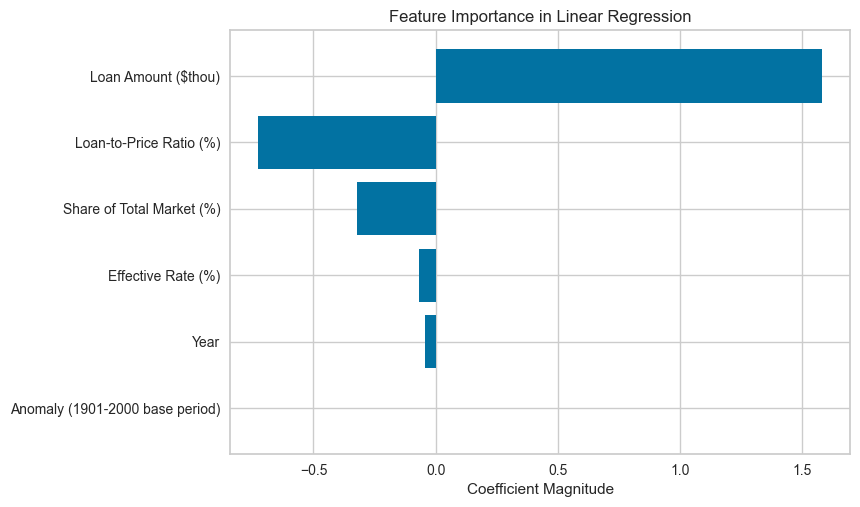

,Feature,Coefficient
1,Anomaly (1901-2000 base period),0.002613
0,Year,-0.044778
2,Effective Rate (%),-0.068928
5,Share of Total Market (%),-0.322493
4,Loan-to-Price Ratio (%),-0.726020
3,Loan Amount ($thou),1.582045


In [88]:
# Pull out the feature importances (the coeficients)
feat_importance = pd.DataFrame({'Feature': X_train_selected.columns, 'Coefficient': l_model.coef_})
feat_importance = feat_importance.sort_values(by='Coefficient', key=abs, ascending=True)

# Creating the bar plot
plt.barh(feat_importance['Feature'], feat_importance['Coefficient'])
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Linear Regression')
plt.show()

feat_importance

The feature importance of **Anomaly (1901-2000 base period)** is extremely low -- it doesn't even show up on the plot -- but it _did_ improve our R2 value for our test data. I think it is worth including.

**Main takeaways:** The linear model is quite good. The MSE is relatively low and the R2 is quite high, and tuned to a decent 'height' of 0.797 via feature selection. The temperature anomaly in each county, compared to the previous century, _is an included feature_ which improves the performance of the model, even if only a little bit. This means that **it is ultimately possible to predict house purchase prices, and temperature anomaly is a contributing feature.**

### Model 2: Polynomial Features

Next, let me try fitting some polynomials. I am going to use our selected data and see what happens with the R2 values as we go through.

In [22]:
y_poly_preds = []
for x in range(1,4):
    # Create the polynomial features object
    X_poly = PolynomialFeatures(degree=x)

    # Fit and transform the data
    X_polynomial_train = X_poly.fit_transform(X_train_selected)
    X_polynomial_test = X_poly.fit_transform(X_test_selected)

    # Create and fit the model
    model_poly = LinearRegression()
    model_poly.fit(X_polynomial_train, y_train)

    # Get predictions
    y_pred_poly_test = model_poly.predict(X_polynomial_test)
    y_pred_poly_train = model_poly.predict(X_polynomial_train)
    y_poly_preds.append(y_pred_poly_test)

    # Get R2 values
    r_squared_train_poly = model_poly.score(X_polynomial_train, y_train)
    r_squared_test_poly = model_poly.score(X_polynomial_test, y_test)

    # Get MSE values
    mean_squared_error_train_poly = mean_squared_error(y_train, y_pred_poly_train)
    mean_squared_error_test_poly = mean_squared_error(y_test, y_pred_poly_test)

    # Printing results for training
    print('----------------------------')
    print("Degree: ", x)
    print('r_squared_train:', r_squared_train_poly)
    print('mean_squared_error_train:', mean_squared_error_train_poly)

    # Printing results for testing
    print('r_squared_test:',r_squared_test_poly)
    print('mean_squared_error_test:',mean_squared_error_test_poly)
    print('----------------------------')
    print("")

----------------------------
Degree:  1
r_squared_train: 0.959846772344187
mean_squared_error_train: 52.40396183663441
r_squared_test: 0.7887957276806994
mean_squared_error_test: 20.89009432046281
----------------------------

----------------------------
Degree:  2
r_squared_train: 0.9838102251438878
mean_squared_error_train: 21.12926888408136
r_squared_test: 0.6385374445631102
mean_squared_error_test: 35.752055550166574
----------------------------

----------------------------
Degree:  3
r_squared_train: 0.9909719221788189
mean_squared_error_train: 11.782540862088041
r_squared_test: 0.4498843809159879
mean_squared_error_test: 54.411622660980726
----------------------------



My computer fails to run anything beyond the 3rd degree -- but it is doubtful that it would help. It clearly begins to overfit to the training data when we increase the polynomial beyond linear.

### Model 3: Ridge Regression
Next, I am going to try fitting a ridge model. This will involve tuning the alpha value. I will try with all features and with features selected with the linear model. If it looks promising, I will do further feature selection; if not, I will move on to Lasso, because Lasso actually can allow for feature selection inherently and may look interesting.

In [106]:
def run_ridge_model(X_train, y_train, X_test, y_test, alpha=None):
    """
    Constructs a Ridge object, fits the train data, and predicts the y_train and y_test data
    and prints the MSE and R2 values.
    X_train, y_train, X_test, y_test: training and testing data
    returns: r_squared_train_ridge, mean_squared_error_train_ridge, r_squared_test_ridge, mean_squared_error_test_ridge, r_model
    """
    # Construct the model, fit the data, and predict
    r_model = Ridge()
    if alpha != None:
        r_model = Ridge(alpha=alpha)
    r_model.fit(X_train, y_train)
    y_pred_train = r_model.predict(X_train)
    y_pred_test = r_model.predict(X_test)

    # Get R2 values
    r_squared_train_ridge = r2_score(y_train, y_pred_train)
    r_squared_test_ridge = r2_score(y_test, y_pred_test)

    # Get MSE values
    mean_squared_error_train_ridge = mean_squared_error(y_train, y_pred_train)
    mean_squared_error_test_ridge = mean_squared_error(y_test, y_pred_test)

    # Printing results for training
    print('r_squared_train:', round(r_squared_train_ridge, 5))
    print('mean_squared_error_train:', round(mean_squared_error_train_ridge, 5))

    # Printing results for testing
    print('r_squared_test:',round(r_squared_test_ridge, 5))
    print('mean_squared_error_test:',round(mean_squared_error_test_ridge, 5))
    return r_squared_train_ridge, mean_squared_error_train_ridge, r_squared_test_ridge, mean_squared_error_test_ridge, r_model


In [108]:
# Run the ridge model with ALL of the features and the default alpha
results = run_ridge_model(X_train, y_train, X_test, y_test)

r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033


With default values, this is not dissimilar to how the linear model performed with all features included. Next let's see how it improves if we tune the alpha value.

In [109]:
# Alpha values to try
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

# Loop through all alphas and try the Ridge model with that value.
for a in alphas:
    print("Alpha: ", a)
    results = run_ridge_model(X_train, y_train, X_test, y_test, a)
    print("")

Alpha:  0.001
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033

Alpha:  0.01
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033

Alpha:  0.1
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54785
mean_squared_error_test: 0.033

Alpha:  1.0
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54786
mean_squared_error_test: 0.033

Alpha:  10
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54799
mean_squared_error_test: 0.03299

Alpha:  100
r_squared_train: 0.9643
mean_squared_error_train: 0.03438
r_squared_test: 0.54937
mean_squared_error_test: 0.03289

Alpha:  1000
r_squared_train: 0.96421
mean_squared_error_train: 0.03447
r_squared_test: 0.56279
mean_squared_error_test: 0.03191

Alpha:  10000
r_squared_train: 0.95789
mean_squared_error_train: 0.04056
r_squared_test: 0.65444
mean_square

At **alpha = 10,000** we see the maximum R2 of 0.6544. This looks promising, actually. Next, let's try on the selected features from the purely linear regression.

In [111]:
# Alphas to loop through -- I tuned this range manually
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

# Loop through the alphas and do what we did above
for a in alphas:
    print("Alpha: ", a)
    run_ridge_model(X_train_selected, y_train, X_test_selected, y_test, a)
    print("")

Alpha:  0.001
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148

Alpha:  0.01
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148

Alpha:  0.1
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79725
mean_squared_error_test: 0.0148

Alpha:  1.0
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79726
mean_squared_error_test: 0.0148

Alpha:  10
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79732
mean_squared_error_test: 0.01479

Alpha:  100
r_squared_train: 0.95968
mean_squared_error_train: 0.03883
r_squared_test: 0.79787
mean_squared_error_test: 0.01475

Alpha:  1000
r_squared_train: 0.95959
mean_squared_error_train: 0.03891
r_squared_test: 0.80284
mean_squared_error_test: 0.01439

Alpha:  10000
r_squared_train: 0.95314
mean_squared_error_train: 0.04513
r_squared_test: 0.80409
m

With the selected features, we hit a maximum R2 of **0.804 at alpha = 10,000.** Even by alpha = 100, the R2 value has just about met the Linear Regression value.

Next, let's try the Lasso model.

### Model 4: Lasso Regression
Again, first let's try with all features, and tune the alpha. Next, let's try with only the selected features for the linear regression, and tune the alpha. Finally, we can see how the model compares to both the Linear and the Ridge regression, and proceed with more feature selection if need be.

In [95]:
# Construct a default Lasso model and fit the train data with all features
lasso = Lasso()
lasso.fit(X_train, y_train)

# Get our predicted values
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

# Get metrics and print them
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
mse_test_lasso = mean_squared_error(y_test, y_pred_test)
r2_train_lasso = lasso.score(X_train, y_train)
r2_test_lasso = lasso.score(X_test, y_test)
print("Train R2:", round(r2_train_lasso, 5))
print("MSE train:", round(mse_train_lasso, 5))
print("Test R2:", round(r2_test_lasso, 5)) 
print("MSE test:", round(mse_test_lasso,5)) 


Train R2: 0.5227
MSE train: 0.45963
Test R2: -6.91228
MSE test: 0.57745


In [96]:
# Alphas to loop through -- this was tuned manually to a range where convergence was seen
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

# Lists to append to
lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []


# Loop through the different alphas and try the model
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)

    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test)
    r2_train_lasso = lasso.score(X_train, y_train)
    r2_test_lasso = lasso.score(X_test, y_test)
    print("Alpha: ", a)
    print("Train R2:", round(r2_train_lasso, 5))
    print("MSE train:", round(mse_train_lasso, 5))
    print("Test R2:", round(r2_test_lasso, 5)) 
    print("MSE test:", round(mse_test_lasso,5)) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  0.001
Train R2: 0.96426
MSE train: 0.03442
Test R2: 0.55142
MSE test: 0.03274

Alpha:  0.01
Train R2: 0.96101
MSE train: 0.03755
Test R2: 0.56098
MSE test: 0.03204

Alpha:  0.1
Train R2: 0.80626
MSE train: 0.18657
Test R2: -0.28594
MSE test: 0.09385

Alpha:  1.0
Train R2: 0.5227
MSE train: 0.45963
Test R2: -6.91228
MSE test: 0.57745

Alpha:  10
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  100
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  1000
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  10000
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  100000
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  1000000
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409



This was not good at all. The best alpha of **0.01** rendered an R2 of **0.561** which is hardly better than the linear without feature selection. Let's try on selected features next.

In [101]:
# Manually tuned these alphas to a decent range in which convergence is observed. Notice -- these alphas are different! 
alphas = [0.0000001, 0.000001, 0.0001, 0.001,0.01,0.1,1.0,10,100,1000]

# Empty lists to append to
lasso_coeffs = []
mse_train_lassos = []
mse_test_lassos = []
r2_train_lassos = []
r2_test_lassos = []

# Loop through and do what we did above, using different alphas
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_selected, y_train)

    y_pred_train = lasso.predict(X_train_selected)
    y_pred_test = lasso.predict(X_test_selected)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test)
    r2_train_lasso = lasso.score(X_train_selected, y_train)
    r2_test_lasso = lasso.score(X_test_selected, y_test)
    print("Alpha: ", a)
    print("Train R2:", round(r2_train_lasso, 5))
    print("MSE train:", round(mse_train_lasso, 5))
    print("Test R2:", round(r2_test_lasso, 5)) 
    print("MSE test:", round(mse_test_lasso,5)) 
    print("")
    
    lasso_coeffs.append(lasso.coef_)
    mse_train_lassos.append(mse_train_lasso)
    mse_test_lassos.append(mse_test_lasso)
    r2_train_lassos.append(r2_train_lasso)
    r2_test_lassos.append(r2_test_lasso)

Alpha:  1e-07
Train R2: 0.95968
MSE train: 0.03883
Test R2: 0.79725
MSE test: 0.0148

Alpha:  1e-06
Train R2: 0.95968
MSE train: 0.03883
Test R2: 0.79725
MSE test: 0.0148

Alpha:  0.0001
Train R2: 0.95968
MSE train: 0.03883
Test R2: 0.79693
MSE test: 0.01482

Alpha:  0.001
Train R2: 0.95965
MSE train: 0.03886
Test R2: 0.79408
MSE test: 0.01503

Alpha:  0.01
Train R2: 0.95671
MSE train: 0.04169
Test R2: 0.75956
MSE test: 0.01755

Alpha:  0.1
Train R2: 0.80626
MSE train: 0.18657
Test R2: -0.28594
MSE test: 0.09385

Alpha:  1.0
Train R2: 0.5227
MSE train: 0.45963
Test R2: -6.91228
MSE test: 0.57745

Alpha:  10
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  100
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409

Alpha:  1000
Train R2: 0.0
MSE train: 0.96299
Test R2: -34.54441
MSE test: 2.59409



For the selected features from the linear regression, the best R2 value we see is 0.79725 for alphas 1e-06 and below. If we need to choose between Lasso, Ridge, and Linear to continue to tune -- Lasso is last on our list.

The best Lasso is still ever so slightly worse than the regular Linear model.

#### Further Feature Selection on the Ridge Model
To be exhaustive and safe -- I want to check different feature selection with Ridge, since it outperformed out best linear model. With other features, it may perform even better. Let's see what SFS says, and go from there.

In [114]:
# Run SequentialFeatureSelector using up to 6 features. (That number is arbitrarily less than the number of features I have 
# because it saves on computation time, NS I already know that this is just a jumping off point for further exploration of the 'best' features.)
alphas = [0.001,0.01,0.1,1.0,10,100,1000,10000,100000,1000000]

for a in alphas:
    print("Alpha ", a)
    print("---------------")
    # For 1 through 6 features, run feature selection
    for i in range(1,6):
        sfs = SequentialFeatureSelector(estimator=Ridge(alpha=a),
                                        n_features_to_select=i,
                                        direction = 'forward',
                                        scoring = 'r2')
        
        # Fit the training data
        sfs = sfs.fit(X_train, y_train)

        # Convert to and print a readable list
        feature_names = np.array(X_train.columns)
        selected_feature_names = feature_names[sfs.get_support()].tolist()
        print(i, " selected feature(s):", selected_feature_names)

        # Run the model with those features so that I can see for myself what the R2 and MSE are
        run_ridge_model(X_train[selected_feature_names], y_train, X_test[selected_feature_names], y_test, a)
        print("")

Alpha  0.001
---------------
1  selected feature(s): ['Year']
r_squared_train: 0.56013
mean_squared_error_train: 0.42358
r_squared_test: -2.23972
mean_squared_error_test: 0.23644

2  selected feature(s): ['Year', 'Loan Amount ($thou)']
r_squared_train: 0.62756
mean_squared_error_train: 0.35865
r_squared_test: -2.37548
mean_squared_error_test: 0.24635

3  selected feature(s): ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)']
r_squared_train: 0.93784
mean_squared_error_train: 0.05986
r_squared_test: 0.33373
mean_squared_error_test: 0.04863

4  selected feature(s): ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.95845
mean_squared_error_train: 0.04001
r_squared_test: 0.67162
mean_squared_error_test: 0.02397

5  selected feature(s): ['Year', 'Initial Fees and Charges (%)', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']
r_squared_train: 0.96295
mean_squared_error_train: 0.03568
r_squared_test

The best R2 test that we see is 0.77073 with **alpha = 10,000** and these 4 features: ['Year', 'Loan Amount ($thou)', 'Loan-to-Price Ratio (%)', 'Share of Total Market (%)']. This lines up with the feature selection done on the Linear Model, and even selects the same 4 features. Therefore, I think our previously selected features are still the best features.

**Main takeaway:** The **Ridge** model with alpha = 10,000 and our previously selected features renders an R2 test slightly higher than 0.80.

r_squared_train: 0.95314
mean_squared_error_train: 0.04513
r_squared_test: 0.80409
mean_squared_error_test: 0.0143


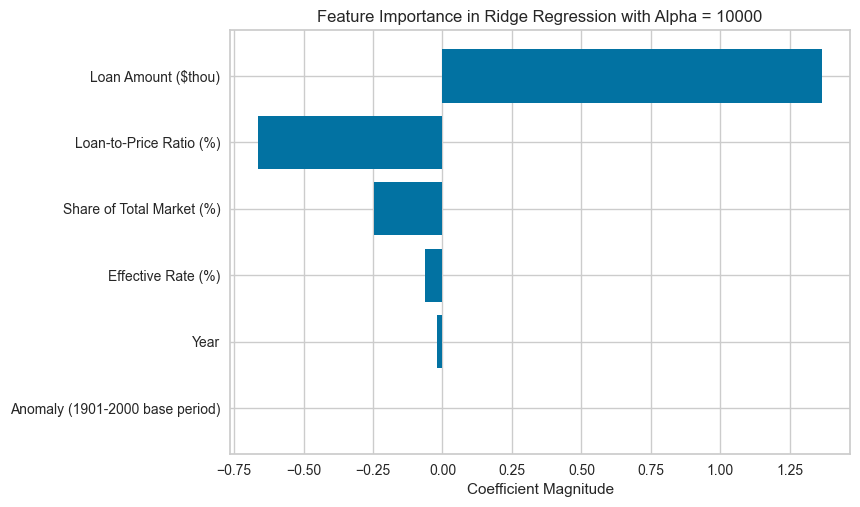

,Feature,Coefficient
1,Anomaly (1901-2000 base period),-0.000500
0,Year,-0.018047
2,Effective Rate (%),-0.062874
5,Share of Total Market (%),-0.246633
4,Loan-to-Price Ratio (%),-0.663076
3,Loan Amount ($thou),1.365870


In [119]:
results = run_ridge_model(X_train_selected, y_train, X_test_selected, y_test, alpha=10000)
# Pull out the feature importances (the coeficients)
feat_importance = pd.DataFrame({'Feature': X_train_selected.columns, 'Coefficient': results[4].coef_})
feat_importance = feat_importance.sort_values(by='Coefficient', key=abs, ascending=True)

# Creating the bar plot
plt.barh(feat_importance['Feature'], feat_importance['Coefficient'])
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Ridge Regression with Alpha = 10000')
plt.show()

feat_importance

### References
1. Homework 1
2. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#:~:text=This%20Sequential%20Feature%20Selector%20adds,validation%20score%20of%20an%20estimator.
4. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py
5. Ridge_and_Lasso_Solution.html